In [4]:
import os
import re
import sys

import matplotlib
import matplotlib.pyplot as plt
import pandas
import yaml

################################################################################
# Boilerplate
################################################################################

# ANSI SGR control codes for text formatting
class Text:
    DEFAULT = "\x1b[0m"
    BOLD = "\x1b[1m"
    BOLD_OFF = "\x1b[22m"
    UNDERLINE = "\x1b[4m"
    UNDERLINE_OFF = "\x1b[24m"
    DEFAULT_COLOR = "\x1b[39m"
    DEFAULT_BG_COLOR = "\x1b[49m"
    RED = "\x1b[31m"
    YELLOW = "\x1b[33m"
    GREEN = "\x1b[32m"
    CYAN = "\x1b[36m"
    BLUE = "\x1b[34m"
    MAGENTA = "\x1b[35m"
    BLACK = "\x1b[30m"
    WHITE = "\x1b[37m"
    BG_RED = "\x1b[41m"
    BG_YELLOW = "\x1b[43m"
    BG_GREEN = "\x1b[42m"
    BG_CYAN = "\x1b[46m"
    BG_BLUE = "\x1b[44m"
    BG_MAGENTA = "\x1b[45m"
    BG_BLACK = "\x1b[40m"
    BG_WHITE = "\x1b[47m"


def warn(mesg: str) -> None:
    sys.stderr.write(f'{Text.YELLOW}{mesg}\n{Text.DEFAULT}')


def error(mesg: str, err_code: int = 1) -> None:
    sys.stderr.write(f'{Text.RED}{mesg}\n{Text.DEFAULT}')
    sys.exit(err_code)


def check_source_dir(source_dir: str) -> None:
    if not os.path.isdir(source_dir):
        sys.stderr.write(f'{Text.RED}Invalid path: {source_dir}\n{Text.DEFAULT}')
        sys.exit(1)


def get_pd_sweep_dirs(source_dir: str) -> list[str]:
    sweep_dirs = []
    for file in os.listdir(source_dir):
        if not os.path.isdir(os.path.join(source_dir, file)):
            # Skip files that are not directories
            continue
        if not re.search('.+\\_\\_[0-9]+P-TP[0-9]+\\_[0-9]+D-TP[0-9]+$', file):
            # Skip directories that do not match a swept run pattern
            continue
        sweep_dirs.append(os.path.join(source_dir, file))

    sweep_dirs.sort()
    return sweep_dirs


def get_sa_sweep_dirs(source_dir: str) -> list[str]:
    sweep_dirs = []
    for file in os.listdir(source_dir):
        if not os.path.isdir(os.path.join(source_dir, file)):
            # Skip files that are not directories
            continue
        if not re.search('.+\\_\\_[0-9]+R-TP[0-9]+$', file):
            # Skip directories that do not match a swept run pattern
            continue
        sweep_dirs.append(os.path.join(source_dir, file))

    sweep_dirs.sort()
    return sweep_dirs


def get_sweep_dirs(source_dirs: list[str]) -> tuple[list[str], list[str]]:
    pd_sweep_dirs = []
    sa_sweep_dirs = []
    for s_dir in source_dirs:
        check_source_dir(s_dir)
        # Get P/D run directories
        pd_sweep_dirs.extend(get_pd_sweep_dirs(s_dir))
        # Get standalone run directories
        sa_sweep_dirs.extend(get_sa_sweep_dirs(s_dir))
    
        if not pd_sweep_dirs and not sa_sweep_dirs:
            error(f'No run directories found in source directory: {s_dir}')
    return (pd_sweep_dirs, sa_sweep_dirs)


def make_pd_df() -> pandas.core.frame.DataFrame:
    # Create DataFrame for PD benchmark run results
    return pandas.DataFrame(columns=[
        'Name',
        'Model',
        'GPU',
        'P_TP',
        'P_Replicas',
        'D_TP',
        'D_Replicas',
        'Concurrency',
        'ISL',
        'OSL',
        'Request_Throughput',
        'Output_Throughput',
        'Total_Token_Throughput',
        'Total_Input_Tokens',
        'Total_Output_Tokens',
        'Completed',
        'Mean_TTFT',
        'Std_TTFT',
        'Mean_TPOT',
        'Std_TPOT',
        'Mean_ITL',
        'Std_ITL',
        'Mean_E2E',
        'Std_E2E',
    ])


def make_sa_df() -> pandas.core.frame.DataFrame:
    # Create DataFrame for standalone benchmark run results
    return pandas.DataFrame(columns=[
        'Name',
        'Model',
        'GPU',
        'TP',
        'Replicas',
        'Concurrency',
        'ISL',
        'OSL',
        'Request_Throughput',
        'Output_Throughput',
        'Total_Token_Throughput',
        'Total_Input_Tokens',
        'Total_Output_Tokens',
        'Completed',
        'Mean_TTFT',
        'Std_TTFT',
        'Mean_TPOT',
        'Std_TPOT',
        'Mean_ITL',
        'Std_ITL',
        'Mean_E2E',
        'Std_E2E',
    ])
    

def import_yaml(file_path: str) -> dict[any, any]:
    with open(file_path, 'r', encoding='UTF-8') as file:
        data = yaml.safe_load(file)
    return data


def get_results_files(run_dir: str) -> list[str]:
    """
    Get list of results files from run.

    If a particular workload has multiple results files, pick newest based on
    filename's date.
    """
    results_files = []
    if not os.path.isdir(run_dir):
        warn(f'Invalid run directory: {run_dir}')
        return results_files
    if not os.path.isdir(os.path.join(run_dir, 'results')):
        warn(f'"results" directory missing in run: {run_dir}')
        return results_files
    # Within the results directory of a run, there can be several benchmarks
    for benchmark in os.listdir(os.path.join(run_dir, 'results')):
        if not os.path.isdir(os.path.join(run_dir, 'results', benchmark)):
            continue
        # Sort files by newest first
        files_sorted = sorted(
            os.listdir(os.path.join(run_dir, 'results', benchmark)),
            # Sorting by modified time will not work if files are copied
            # locally in arbitrary order
            #key=lambda ff: os.path.getmtime(os.path.join(run_dir, "results", benchmark, ff)),
            reverse=True)
        for file in files_sorted:
            if not os.path.isfile(os.path.join(run_dir, 'results', benchmark, file)):
                continue
            if not re.search('^vllm.+\\.json$', file):
                # Skip files that do not match result data filename
                continue
            results_files.append(os.path.join(run_dir, 'results', benchmark, file))
            break
    return results_files


def get_workload_profile(run_dir: str) -> dict[str, any]:
    """Get workload profile file from run."""
    if not os.path.isdir(run_dir):
        error(f'Invalid run directory: {run_dir}')
    if not os.path.isdir(os.path.join(run_dir, 'workload')):
        error(f'"workload" directory missing in run: {run_dir}')
    if not os.path.isdir(os.path.join(run_dir, 'workload', 'profiles')):
        error(f'"workload/profiles" directory missing in run: {run_dir}')
    # Get the workload file (there should be only one, and we will assume this)
    for file in os.listdir(os.path.join(run_dir, 'workload', 'profiles')):
        if os.path.isdir(os.path.join(run_dir, 'workload', 'profiles', file)):
            continue
        if not re.search('.+\\.yaml$', file):
            # Skip files that do not match result data filename
            continue
        return import_yaml(os.path.join(run_dir, 'workload', 'profiles', file))


def get_envar(run_dir: str, envar: str) -> str:
    """Get value of environment variable in environment/variables file of run."""
    if not os.path.isdir(run_dir):
        error(f'Invalid run directory: {run_dir}')
    if not os.path.isdir(os.path.join(run_dir, "environment")):
        error(f'"environment" directory missing in run: {run_dir}')
    if not os.path.isfile(os.path.join(run_dir, "environment", "variables")):
        error(f'"variables" file missing in run: {os.path.join(run_dir, "environment")}')
    with open(os.path.join(run_dir, "environment", "variables"), "r", encoding="UTF-8") as file:
        for line in file:
            if envar in line:
                model = line.rsplit('=', 1)[-1].strip()
                if not model:
                    error(f'{envar} not defined: {run_dir}')
                return model
        error(f'{envar} missing from environment/variables: {run_dir}')


def populate_pd_df(runs_df: pandas.core.frame.DataFrame, sweep_dirs: list[str]) -> None:
    # Import data and populate DataFrame
    for s_dir in sweep_dirs:
        results_files = get_results_files(s_dir)
        model = get_envar(s_dir, 'LLMDBENCH_DEPLOY_MODEL_LIST')
        gpu = get_envar(s_dir, 'LLMDBENCH_VLLM_COMMON_AFFINITY').rsplit(':', 1)[-1]
        name, config_str = s_dir.rsplit('__', 1)
        name = name.rsplit('/', 1)[-1]
        p_rep = int(config_str.split('P-TP', 1)[0])
        p_tp = int(config_str.split('P-TP', 1)[1].split('_', 1)[0])
        d_rep = int(config_str.rsplit('_', 1)[1].split('D-TP', 1)[0])
        d_tp = int(config_str.split('D-TP', 1)[1])
        workload_profile = get_workload_profile(s_dir)
        for rf in results_files:
            result_data = import_yaml(rf)
            runs_df.loc[len(runs_df)] = {
                'Name': name,
                'Model': model,
                'GPU': gpu,
                'P_TP': p_tp,
                'P_Replicas': p_rep,
                'D_TP': d_tp,
                'D_Replicas': d_rep,
                'Concurrency': result_data['max_concurrency'],
                'ISL': workload_profile['random-input-len'],
                'OSL': workload_profile['random-output-len'],
                'Request_Throughput': result_data['request_throughput'],
                'Output_Throughput': result_data['output_throughput'],
                'Total_Token_Throughput': result_data['total_token_throughput'],
                'Total_Input_Tokens': result_data['total_input_tokens'],
                'Total_Output_Tokens': result_data['total_output_tokens'],
                'Completed': result_data['completed'],
                'Mean_TTFT': result_data['mean_ttft_ms'],
                'Std_TTFT': result_data['std_ttft_ms'],
                'Mean_TPOT': result_data['mean_tpot_ms'],
                'Std_TPOT': result_data['std_tpot_ms'],
                'Mean_ITL': result_data['mean_itl_ms'],
                'Std_ITL': result_data['std_itl_ms'],
                'Mean_E2E': result_data['mean_e2el_ms'],
                'Std_E2E': result_data['std_e2el_ms'],
            }
    # Add calculated columns
    runs_df['Num_GPUs'] = runs_df['P_TP']*runs_df['P_Replicas'] + runs_df['D_TP']*runs_df['D_Replicas']
    runs_df['Thpt_per_GPU'] = runs_df['Output_Throughput']/runs_df['Num_GPUs']
    runs_df['Thpt_per_User'] = runs_df['Output_Throughput']/runs_df['Concurrency']


def populate_sa_df(runs_df: pandas.core.frame.DataFrame, sweep_dirs: list[str]) -> None:
    # Import data and populate DataFrame
    for s_dir in sweep_dirs:
        results_files = get_results_files(s_dir)
        model = get_envar(s_dir, 'LLMDBENCH_DEPLOY_MODEL_LIST')
        gpu = get_envar(s_dir, 'LLMDBENCH_VLLM_COMMON_AFFINITY').rsplit(':', 1)[-1]
        name, config_str = s_dir.rsplit('__', 1)
        name = name.rsplit('/', 1)[-1]
        rep = int(config_str.split('R-TP', 1)[0])
        tp = int(config_str.split('R-TP', 1)[-1])
        workload_profile = get_workload_profile(s_dir)
        for rf in results_files:
            result_data = import_yaml(rf)
            runs_df.loc[len(runs_df)] = {
                'Name': name,
                'Model': model,
                'GPU': gpu,
                'TP': tp,
                'Replicas': rep,
                'Concurrency': result_data['max_concurrency'],
                'ISL': workload_profile['random-input-len'],
                'OSL': workload_profile['random-output-len'],
                'Request_Throughput': result_data['request_throughput'],
                'Output_Throughput': result_data['output_throughput'],
                'Total_Token_Throughput': result_data['total_token_throughput'],
                'Total_Input_Tokens': result_data['total_input_tokens'],
                'Total_Output_Tokens': result_data['total_output_tokens'],
                'Completed': result_data['completed'],
                'Mean_TTFT': result_data['mean_ttft_ms'],
                'Std_TTFT': result_data['std_ttft_ms'],
                'Mean_TPOT': result_data['mean_tpot_ms'],
                'Std_TPOT': result_data['std_tpot_ms'],
                'Mean_ITL': result_data['mean_itl_ms'],
                'Std_ITL': result_data['std_itl_ms'],
                'Mean_E2E': result_data['mean_e2el_ms'],
                'Std_E2E': result_data['std_e2el_ms'],
            }
    # Add calculated columns
    runs_df['Num_GPUs'] = runs_df['TP']*runs_df['Replicas']
    runs_df['Thpt_per_GPU'] = runs_df['Output_Throughput']/runs_df['Num_GPUs']
    runs_df['Thpt_per_User'] = runs_df['Output_Throughput']/runs_df['Concurrency']


def get_scenarios(runs_df: pandas.core.frame.DataFrame) -> list[tuple[str]]:
    """Get a list of available scenarios from runs DataFrame, where
    configurations and concurrency will be swept"""
    columns = ['Model', 'GPU', 'ISL', 'OSL']
    return list(set(runs_df.set_index(columns).index))


def print_scenarios(scenarios: list[str]) -> None:
    """Print a formatted table of scenarios"""
    columns = ['Model', 'GPU', 'ISL', 'OSL']
    # Get maximum text length for each column, including header
    spans = list(map(len, columns))
    for sc in scenarios:
        for jj, item in enumerate(sc):
            if spans[jj] < len(str(item)):
                spans[jj] = len(str(item))
    
    header = f'{Text.BOLD}{Text.BLUE}IDX  {Text.BLACK}'
    for ii, col in enumerate(columns):
        header += col + " " * (spans[ii] - len(col) + 2)
    header += f'{Text.DEFAULT}'
    print(header)
    for ii, sc in enumerate(scenarios):
        row = f'{Text.BLUE}{ii}{Text.DEFAULT}' + " " * (5 - len(str(ii)))
        for jj, val in enumerate(sc):
            row += f'{str(val)}' + " " * (spans[jj] - len(str(val)) + 2)
        print(row)

In [5]:
################################################################################
# Import data
################################################################################

# List of directories containing sweep directories to import.
# These can be a mix of PD and standalone sweeps.
source_dirs = [
    "/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/fusionv6/qwen/ISL-OSL_10000-100/",
    "/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/fusionv6/qwen/ISL-OSL_10000-1000/",
    "/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/fusionv6/scout/ISL-OSL_30000-300/",
    "/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/CW/sanity_PD_comparison,_qwen,_ISL-OSL_10000-1000/",
    "/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/CW/scout/",
]

pd_runs = make_pd_df()
sa_runs = make_sa_df()

pd_sweep_dirs, sa_sweep_dirs = get_sweep_dirs(source_dirs)
populate_pd_df(pd_runs, pd_sweep_dirs)
populate_sa_df(sa_runs, sa_sweep_dirs)

# PD Disaggregated

In [10]:
# Scenarios available, sweeping P and D replicas/TP configurations and concurrency
pd_scenarios = get_scenarios(pd_runs)
print_scenarios(pd_scenarios)

IDX  Model                        GPU                    ISL    OSL   
0    Qwen/Qwen1.5-MoE-A2.7B-Chat  H200                   10000  1000  
1    Qwen/Qwen1.5-MoE-A2.7B-Chat  NVIDIA-H100-80GB-HBM3  10000  1000  
2    rs-test/llama-scout-fp8      H200                   10000  1000  


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Thpt_per_GPU,Thpt_per_User
70,2,4,8,1,8,499.425315,31.214082,62.428164
74,2,4,8,1,96,1462.267479,91.391717,15.231953
71,2,4,8,1,192,1211.229743,75.701859,6.308488
72,2,4,8,1,384,1311.495040,81.968440,3.415352
73,2,4,8,1,768,122.052239,7.628265,0.158922


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Throughput,Thpt_per_GPU,Thpt_per_User
75,2,6,4,1,8,452.248950,28.265559,56.531119
79,2,6,4,1,96,1277.810821,79.863176,13.310529
76,2,6,4,1,192,1399.215212,87.450951,7.287579
77,2,6,4,1,384,1345.452304,84.090769,3.503782
78,2,6,4,1,768,1107.438730,69.214921,1.441978


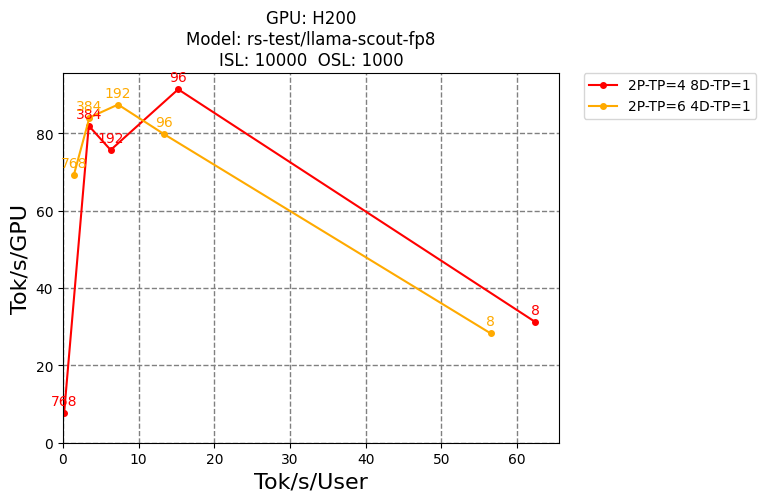

In [13]:
# Select scenario
idx = 2

# Get parameters of selected scenario
model, gpu, isl, osl = pd_scenarios[idx]

# Filter on column values
pd_runs_selected = pd_runs[
    (pd_runs['Model'] == model) &
    (pd_runs['GPU'] == gpu) &
    (pd_runs['ISL'] == isl) &
    (pd_runs['OSL'] == osl)][[
    'Model',
    'GPU',
    'P_TP',
    'P_Replicas',
    'D_TP',
    'D_Replicas',
    'Concurrency',
    'ISL',
    'OSL',
    'Output_Throughput',
    'Thpt_per_GPU',
    'Thpt_per_User']].drop('Model', axis=1).drop('GPU', axis=1).drop('ISL', axis=1).drop('OSL', axis=1)#.sort_values(by='Output_Throughput')

# Plot performance results
colors = ['#FF0000', '#FFAA00', '#DDDD00', '#00DD00', '#00FFFF', '#0000FF',
          '#FF00FF', '#666666', '#000000']

# Unique configurations of replicas and TP
configs = set(pd_runs_selected.set_index(['P_Replicas', 'P_TP', 'D_Replicas', 'D_TP']).index)
# Sweep through configurations
for ii, conf in enumerate(configs):
    # Make a DataFrame for specific configuration
    conf_df = pd_runs_selected[
        (pd_runs_selected['P_Replicas'] == conf[0]) &
        (pd_runs_selected['P_TP'] == conf[1]) &
        (pd_runs_selected['D_Replicas'] == conf[2]) &
        (pd_runs_selected['D_TP'] == conf[3])
    ].sort_values(by='Concurrency')
    display(conf_df)

    # Plot throughputs for configuration
    plt.plot(conf_df.Thpt_per_User, conf_df.Thpt_per_GPU,
             label=f'{conf[1]}P-TP={conf[0]} {conf[3]}D-TP={conf[2]}',
             marker='o', markersize=4,
             color=colors[ii%len(colors)]
            )
    for jj, val in enumerate(conf_df.Concurrency):
        plt.text(list(conf_df.Thpt_per_User)[jj],
                 list(conf_df.Thpt_per_GPU)[jj]+2,
                 str(val), ha='center', color=colors[ii%len(colors)])

plt.title(f'GPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
plt.xlabel('Tok/s/User', fontsize='16')
plt.ylabel('Tok/s/GPU', fontsize='16')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, linewidth=1, ls='--', color='gray')
plt.axis([0, None, 0, None])
plt.show()


# Standalone

In [6]:
# Scenarios available, sweeping replicas/TP configurations and concurrency
sa_scenarios = get_scenarios(sa_runs)
print_scenarios(sa_scenarios)

IDX  Model                        GPU                    ISL    OSL   
0    rs-test/llama-scout-fp8      NVIDIA-H100-80GB-HBM3  30000  300   
1    Qwen/Qwen1.5-MoE-A2.7B-Chat  NVIDIA-H100-80GB-HBM3  10000  100   
2    Qwen/Qwen1.5-MoE-A2.7B-Chat  NVIDIA-H100-80GB-HBM3  10000  1000  


,TP,Replicas,Concurrency,Output_Throughput,Thpt_per_GPU,Thpt_per_User
55,2,1,1,57.978969,28.989484,57.978969
56,2,1,4,125.197808,62.598904,31.299452
59,2,1,8,129.759342,64.879671,16.219918
57,2,1,32,129.216969,64.608484,4.038030
58,2,1,128,129.164935,64.582468,1.009101


,TP,Replicas,Concurrency,Output_Throughput,Thpt_per_GPU,Thpt_per_User
64,4,1,1,71.094570,17.773643,71.094570
63,4,1,4,168.151380,42.037845,42.037845
61,4,1,8,225.310613,56.327653,28.163827
62,4,1,32,303.325540,75.831385,9.478923
60,4,1,128,304.118429,76.029607,2.375925


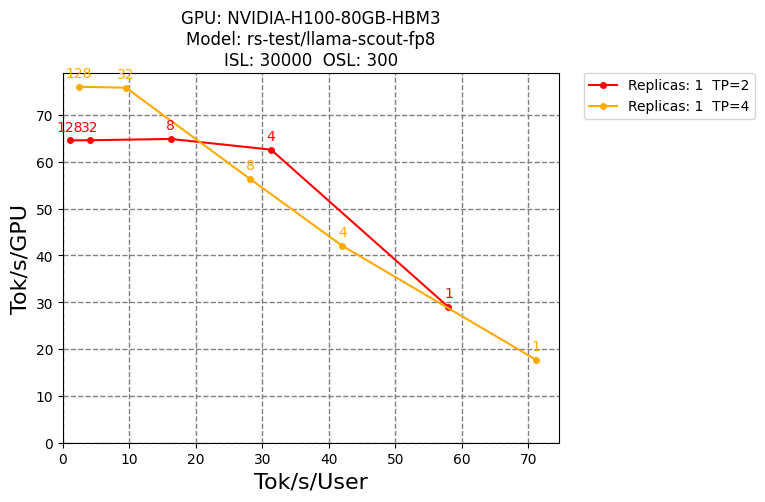

In [15]:
# Select scenario
idx = 0

# Get parameters of selected scenario
model, gpu, isl, osl = sa_scenarios[idx]

# Filter on column values
sa_runs_selected = sa_runs[
    (sa_runs['Model'] == model) &
    (sa_runs['GPU'] == gpu) &
    (sa_runs['ISL'] == isl) &
    (sa_runs['OSL'] == osl)][[
    'Model',
    'GPU',
    'TP',
    'Replicas',
    'Concurrency',
    'ISL',
    'OSL',
    'Output_Throughput',
    'Thpt_per_GPU',
    'Thpt_per_User']].drop('Model', axis=1).drop('GPU', axis=1).drop('ISL', axis=1).drop('OSL', axis=1)#.sort_values(by='Output_Throughput')

# Plot performance results
colors = ['#FF0000', '#FFAA00', '#DDDD00', '#00DD00', '#00FFFF', '#0000FF',
          '#FF00FF', '#666666', '#000000']

# Unique configurations of replicas and TP
configs = list(set(sa_runs_selected.set_index(['Replicas', 'TP']).index))
configs.sort()
# Sweep through configurations
for ii, conf in enumerate(configs):
    # Make a DataFrame for specific configuration
    conf_df = sa_runs_selected[
        (sa_runs_selected['Replicas'] == conf[0]) &
        (sa_runs_selected['TP'] == conf[1])
    ].sort_values(by='Concurrency')
    display(conf_df)

    # Plot throughputs for configuration
    plt.plot(conf_df.Thpt_per_User, conf_df.Thpt_per_GPU,
             label=f'Replicas: {conf[0]}  TP={conf[1]}',
             marker='o', markersize=4,
             color=colors[ii%len(colors)]
            )
    for jj, val in enumerate(conf_df.Concurrency):
        plt.text(list(conf_df.Thpt_per_User)[jj],
                 list(conf_df.Thpt_per_GPU)[jj]+2,
                 str(val), ha='center', color=colors[ii%len(colors)])

plt.title(f'GPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
plt.xlabel('Tok/s/User', fontsize='16')
plt.ylabel('Tok/s/GPU', fontsize='16')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, linewidth=1, ls='--', color='gray')
plt.axis([0, None, 0, None])
plt.show()
